In [6]:
using LCIO
using GRUtils
using FastJet
using CxxWrap: StdVector
using LinearAlgebra
#using StatsPlots
#using Plots

# We are setting up the jet algorithm
# for details, see "A new jet reconstruction algorithm for lepton colliders"
# https://arxiv.org/abs/1404.4294

read 1000 events


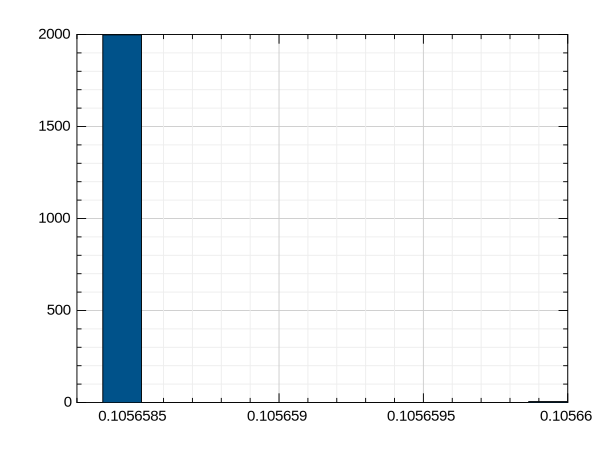

In [8]:
jetMassList = Float64[]
wMuonNJetList = Float64[]
wMuonNParticleList = Float64[]
muonInvMassList = []

vp = FastJet.ValenciaPlugin(1.2, 0.8)
jet_def = JetDefinition(vp)

LCIO.open("E250-TDR_ws.Pe2e2h_ss.Gwhizard-2_82.eR.pL (1).slcio") do reader
    iEvent = 0
    for event in reader
        iEvent += 1
        if iEvent == 1000
            break
        end
        iParticle = 0
        iMuon = 0
        particles = PseudoJet[]
        for particle in getCollection(event, "MCParticle")
            iParticle += 1
            if abs(getPDG(particle))==13 && getGeneratorStatus(particle)==1
                push!(muonInvMassList, invMass(particle))
            end
            if getGeneratorStatus(particle) != 1
                continue
            end
            E = getEnergy(particle)
            p = getMomentum(particle)
            # FastJet doesn't operate on LCIO particles, unfortunately. It wants its own input format.
            push!(particles, PseudoJet(p[1], p[2], p[3], E))
        end
        # after preparing the input, we can run the tool
        cs = ClusterSequence(StdVector(particles), jet_def)
        # We want 4 jets. Ideally, we'll have one muon from the Z each in two of the jets
        # and particles corresponding to the strange quarks in the other two.
        # This is the lazy way to do the reconstruction.
        # A better way is to find the muons from the Z _first_, and then hand the rest to the jet finder.
        jets = exclusive_jets(cs, 4)
        push!(wMuonNJetList, length(jets))
        for j in jets
            # this is just for demonstration how to figure out what particles are in which jet
            # we have forced the event into four jets, so if we don't get back exactly 4 here, something wrong.
            push!(wMuonNParticleList, length(constituents(j)))
        end
    end
    println("read ", iEvent, " events")
end

#histogram(nJetList)
#savefig("nJets.pdf")

#histogram(nParticleList, nbins=100)
#savefig("nParticles.pdf")
subplot(1,1,1)
histogram(muonInvMassList)

In [9]:
function invMassSum(particle_1, particle_2)
    a = sqrt((getEnergy(particle_1)+getEnergy(particle_2))^2-
        dot(getMomentum(particle_1)+getMomentum(particle_2),
            getMomentum(particle_1)+getMomentum(particle_2)))
    return a
end

function invMassSum(particle_1::FastJet.PseudoJet, particle_2::FastJet.PseudoJet)
    a = sqrt((E(particle_1)+E(particle_2))^2-
        dot(jetConstituentP(particle_1).+jetConstituentP(particle_2),
            jetConstituentP(particle_1).+jetConstituentP(particle_2)))
    return a
end

function invMass(particle)
    return sqrt(getEnergy(particle)^2-dot(getMomentum(particle), getMomentum(particle)))
end

function jetMass(jet)
    energy=0
    x=0
    y=0
    z=0
    for c in constituents(jet)
        energy+=FastJet.e(c)
        x+=FastJet.px(c)
        y+=FastJet.py(c)
        z+=FastJet.pz(c)
    end
    return sqrt(energy^2-dot((x,y,z), (x,y,z)))
end

function jetConstituentP(constituent)
    a=FastJet.px(constituent)::Float64
    b=FastJet.py(constituent)::Float64
    c=FastJet.pz(constituent)::Float64
    return (a,b,c)
end

function leadingParticleIndex(jet)
    momentumList = []
    highestMomentum = 0
    nCon = 0
    index = 0
    for c in constituents(jet)
        nCon+=1
        p=jetConstituentP(c)
        if dot(p, p)>highestMomentum
            highestMomentum=dot(p, p)
            index=nCon
        end
    end
    return index
end
    
function zMuonIndices(data, threshold)
    
    iParticle = 0
    posMuonList = []
    negMuonList = []
    for particle in getCollection(data, "MCParticle")
        iParticle += 1
        if abs(getPDG(particle))==13 && getGeneratorStatus(particle)==1
            if getCharge(particle)==1
                push!(posMuonList, (particle, iParticle))
            elseif getCharge(particle)==-1
                push!(negMuonList, (particle, iParticle))
            end
        end
    end
    
    candidatePair=[]
    
    candidateDiff=91.187
    for item_pos in posMuonList    
        posParticle = item_pos[1]
        for item_neg in negMuonList
            negParticle = item_neg[1]
            if abs(91.187-invMassSum(posParticle, negParticle))<abs(candidateDiff)
                candidateDiff=91.187-invMassSum(posParticle, negParticle)
                candidatePair=[item_pos, item_neg]
            end
        end
    end
    
    indices = [candidatePair[1][2], candidatePair[2][2]]
    if abs(candidateDiff)>threshold
        indices=[0,0]
    end
    return indices
end

zMuonIndices (generic function with 1 method)

In [10]:
nParticleList = Float64[]
nJetList = Float64[]
JetMassList = Float64[]
JetMomentumList = Float64[]
avgJetMomentumList = Float64[]
avgJetMassList = Float64[]
leadingParticleMassList = Float64[]
leadingParticlePList = Float64[]
jetPairMassList = Float64[]
leadMomentumFraction = [] #what fraction of the jet's momentum is carries by the particle with the greatest momentum

vp = FastJet.ValenciaPlugin(1.2, 0.8)
jet_def = JetDefinition(vp)

LCIO.open("E250-TDR_ws.Pe2e2h_ss.Gwhizard-2_82.eR.pL (1).slcio") do reader
    iEvent = 0
    for event in reader 
        if iEvent == 1000
            break
        end
        iEvent += 1
        iParticle = 0
        muon_from_Z = zMuonIndices(event, 5)
        particles = PseudoJet[]
        for particle in getCollection(event, "MCParticle")
            iParticle+=1
            if iParticle in muon_from_Z
                continue
            end
            if getGeneratorStatus(particle)!=1
                continue
            end
            E = getEnergy(particle)
            p = getMomentum(particle)
            push!(particles, PseudoJet(p[1], p[2], p[3], E))
        end
        cs = ClusterSequence(StdVector(particles), jet_def)
        jets = exclusive_jets(cs, 2)
        push!(nJetList, length(jets))
        nJet=0
        for j in jets
            nJet+=1
            nCon=0
            jetTotalMomentum=(0,0,0)
            leadMomentum = 0
            for c in constituents(j)
                nCon+=1
                if nCon==1
                    jetTotalMomentum=jetConstituentP(c)
                elseif nCon>1
                    jetTotalMomentum=jetTotalMomentum.+jetConstituentP(c)
                end
                if nCon==leadingParticleIndex(j)
                    push!(leadingParticleMassList, sqrt(FastJet.e(c)^2-
                        dot((FastJet.px(c), FastJet.py(c), FastJet.pz(c)),
                                (FastJet.px(c), FastJet.py(c), FastJet.pz(c)))+10^(-10)))
                    leadMomentum = sqrt(dot((FastJet.px(c), FastJet.py(c), FastJet.pz(c)),
                            (FastJet.px(c), FastJet.py(c), FastJet.pz(c)))+10^(-10))
                    push!(leadingParticlePList, leadMomentum)                    
                end
            end
            jetMomentumMagnitude = sqrt(dot(jetTotalMomentum, jetTotalMomentum))
            push!(nParticleList, length(constituents(j)))
            push!(JetMassList, jetMass(j))
            push!(avgJetMassList, jetMass(j)/length(constituents(j)))
            push!(JetMomentumList, jetMomentumMagnitude)
            push!(avgJetMomentumList, jetMomentumMagnitude/length(constituents(j)))
            push!(leadMomentumFraction, leadMomentum/jetMomentumMagnitude)
        end
        push!(jetPairMassList, invMassSum(jets[1], jets[2]))
    end
    println("read ", iEvent, " events")
end

#histogram(nJetList)

read 1000 events


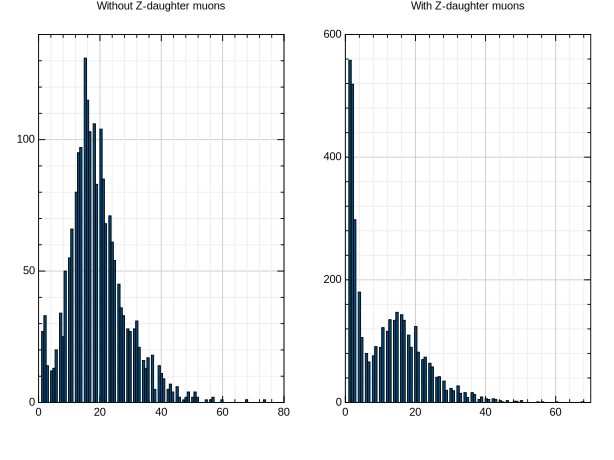

In [11]:
subplot(1,2,1)
histogram(nParticleList, nbins=100, title="Without Z-daughter muons")

subplot(1,2,2)
histogram(wMuonNParticleList, nbins=100, title="With Z-daughter muons")

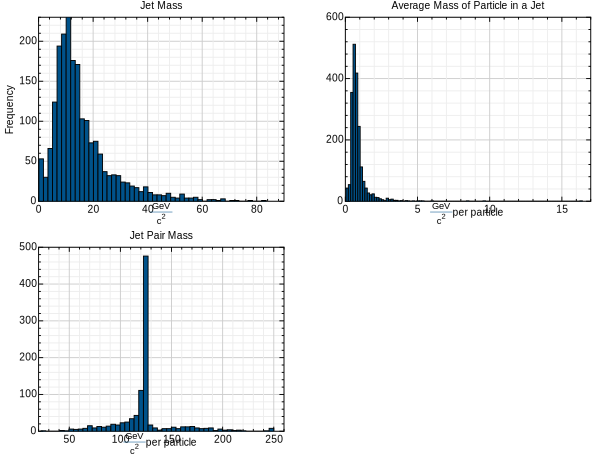

In [21]:
subplot(2,2,1)
histogram(JetMassList, title="Jet Mass", xlabel="GeV/c^2", ylabel="Frequency", nbins=50)

subplot(2,2,2)
histogram(avgJetMassList, title="Average Mass of Particle in a Jet", xlabel="(GeV/c^2) per particle", nbins=100)

subplot(2,2,3)
histogram(jetPairMassList, title="Jet Pair Mass", xlabel="(GeV/c^2) per particle", bins=50:150, nbins=50)

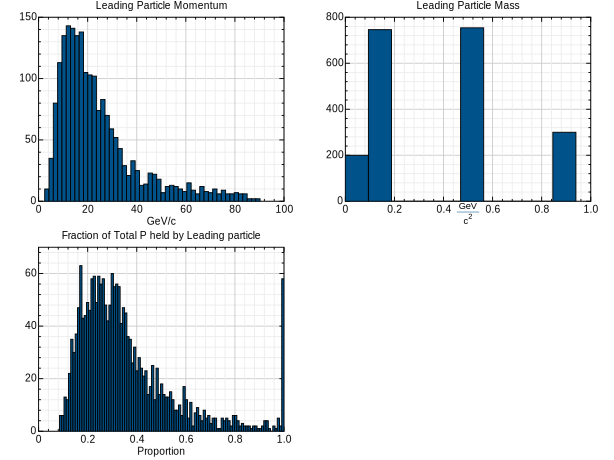

In [22]:
subplot(2,2,1)
histogram(leadingParticlePList,  title="Leading Particle Momentum", xlabel="GeV/c", nbins=50)

subplot(2,2,2)
histogram(leadingParticleMassList,  title="Leading Particle Mass", xlabel="(GeV/c^2)", nbins=10)

subplot(2,2,3)
histogram(leadMomentumFraction, title="Fraction of Total P held by Leading particle", xlabel="Proportion", nbins=100)